# Encoder models - BERT

The transformer model originally has been developed with a focus on language translation. However, its architecture has been used for many different models
that differ in the way which parts of the transformer are used and which training objective is used for parameter calibration. A popular model with this respect is the BERT model which stands for Bidirectional Encoder Representations from Transformers. The original paper can be found [here](https://arxiv.org/abs/1810.04805). Its architecture uses the encoder of the transformer, only, as illustrated in the picture below. Furthermore, it trains the positional embeddings instead of using the trigonometric functions as the transformer.

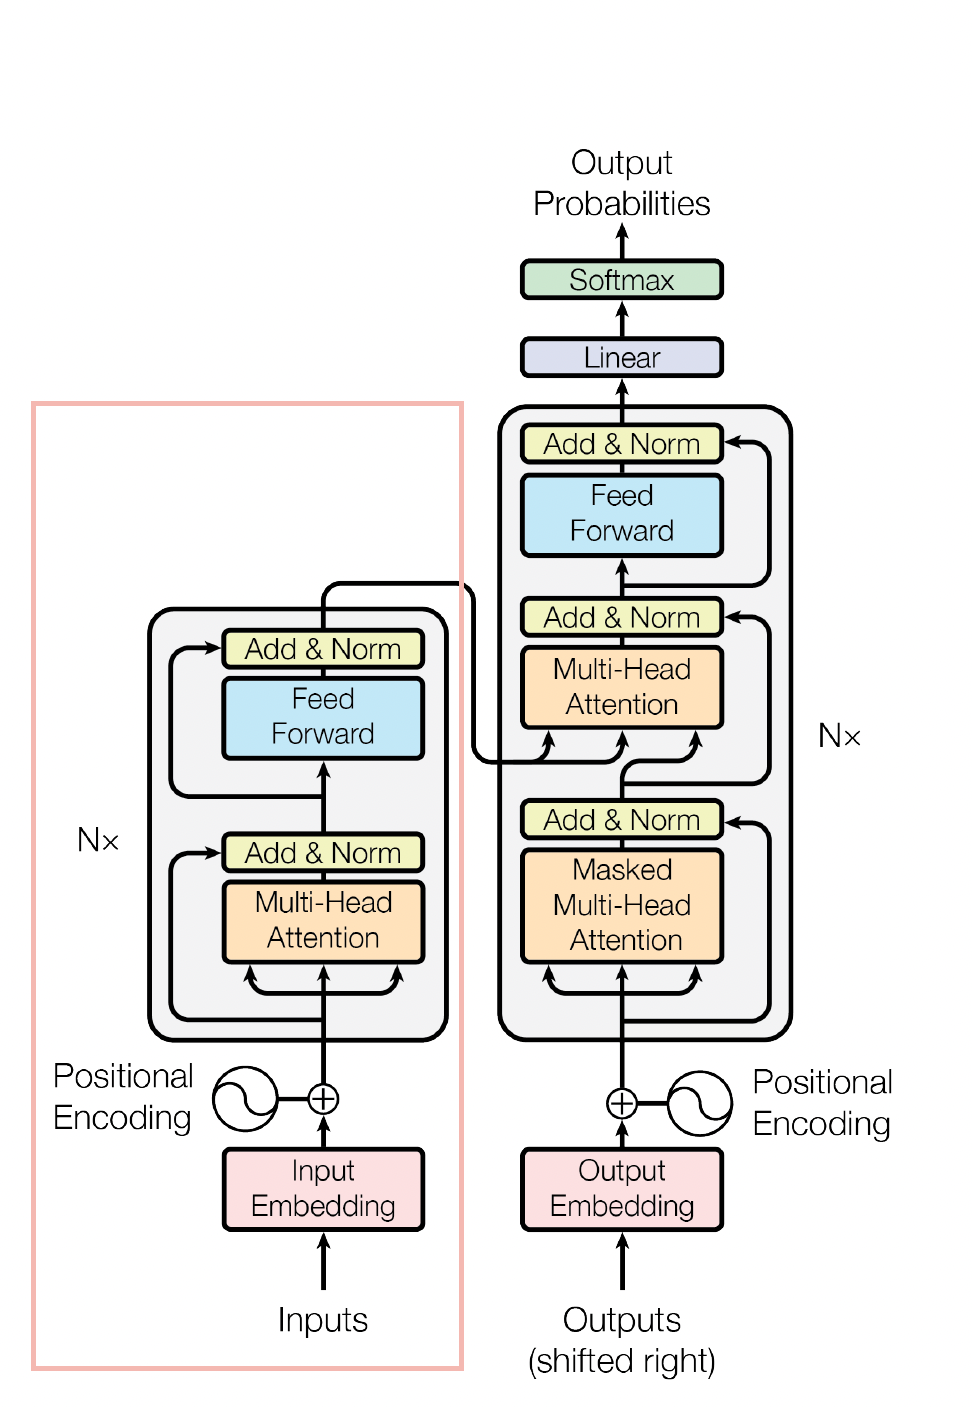

In [1]:
from IPython.display import Image
Image(filename='bert.png', width=400) 

One of the reasons for the popularity of the BERT model is its versatility which comes from the training routine of the model. The parameters of the model are first trained by pre-training which trains the model by two tasks: (1) Masked Language Modeling (MLM) and (2) Next Sentence Prediction (NSP). The aim for MLM is to predict missing words in a sentence. NSP aims to predict which sentences belong together. 

## Masked Language Modeling

To train bidirectional representations, a fraction of tokens from a sentence is masked and the corresponding embedding is used to predict the masked word. Let us take a look at an example in the cell below. First we import a BERT model which is used to encode the example sentences. The embedding dimension of the BERT model is 768. This means every token is represented by 768 numbers. Sentences need to be pre-processed in the same way as the original model has been trained. After pre-processing, we observe that a \[CLS\] and a \[SEP\] token is included in the beginning and the end of the sentence, respectively. We come to this at a later stage. With this pre-processed version, the sentence has length 11 which is why the output of the BERT model has dimension $11 \times 768$. Another important aspect is the the numerical representation of the same word differs w.r.t. to its context. This is demonstrated by taking a look at the first ten embedding numbers of the word *the* in the beginning and the end of the sentence. Before the model applies its attention mechanism, the word embedding is the same. Positional embeddings which are added to the word already change the numerical representation of the word *the* in the beginning and end of the sentence, respectively. However, only due to their position in the sentence. Once these embeddings are processed through the attention layers, the embeddings for the word also change due to the context in which they are to the words in the sequence.

In [2]:
from transformers import BertTokenizer, BertModel
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

text = [
    "The dog would like a piece of the sandwich",
    "I like to eat ice-cream",
    "A dog is a good friend"
] 

encoded_input = tokenizer(text[0], return_tensors='pt')

with torch.inference_mode():
    output = model(**encoded_input, output_attentions = True)

line_split = '-'*100
print(f'\n Preprocessed example sentence number 1:\n{line_split}')
print([tokenizer.ids_to_tokens[id] for id in  encoded_input.input_ids.squeeze().tolist()])

print(f'\n Corresponding token ids:\n{line_split}')
print(encoded_input.input_ids.squeeze().tolist())

print(f'\n Shape of the BERT output for this sentence:\n{line_split}')
print(output.last_hidden_state.shape)

print(f'\n First ten embedding numbers for the word embedding "the" before processing through the encoder:\n{line_split}')
print(model.embeddings.word_embeddings.weight[1996, :10].detach())

print(f'\n First ten embedding numbers for the word "the" in the sentence beginning:\n{line_split}')
print(output.last_hidden_state[0, 1, :10])

print(f'\n First ten embedding numbers for the word "the" in the sentence ending:\n{line_split}')
print(output.last_hidden_state[0, 8, :10])

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.



 Preprocessed example sentence number 1:
----------------------------------------------------------------------------------------------------
['[CLS]', 'the', 'dog', 'would', 'like', 'a', 'piece', 'of', 'the', 'sandwich', '[SEP]']

 Corresponding token ids:
----------------------------------------------------------------------------------------------------
[101, 1996, 3899, 2052, 2066, 1037, 3538, 1997, 1996, 11642, 102]

 Shape of the BERT output for this sentence:
----------------------------------------------------------------------------------------------------
torch.Size([1, 11, 768])

 First ten embedding numbers for the word embedding "the" before processing through the encoder:
----------------------------------------------------------------------------------------------------
tensor([-0.0446,  0.0061, -0.0022,  0.0023, -0.0365,  0.0054,  0.0036,  0.0094,
         0.0192,  0.0027])

 First ten embedding numbers for the word "the" in the sentence beginning:
--------------------

Due to the large number of hidden layers and attention heads in the original BERT model (12 layers, 12 heads), it is hard to interpret single attention matrices. However, let us take a look at one matrix below. This is the attention of the trained model for layer number 6 and attention head 1. The first occurrence of *the* puts its highest attention to the word *dog*, while the second occurrence puts its highest attention to the word *sandwich*. Intuitively, this makes sense and as a consequence, the numerical representations of the same word are changed due to their context. 

<Axes: >

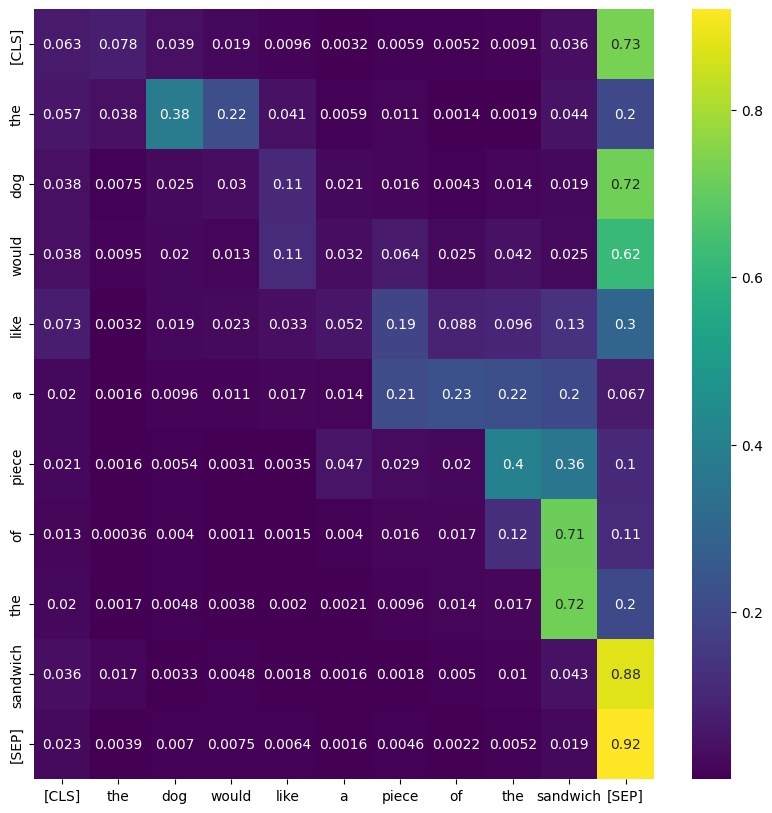

In [3]:
import seaborn as sns
import matplotlib.pylab as plt

fig, ax = plt.subplots(figsize = (10, 10))

sns.heatmap(output.attentions[5][0, 0, :, :].numpy(),
            cmap = "viridis",
            annot = True,
            xticklabels=[tokenizer.ids_to_tokens[id] for id in  encoded_input.input_ids.squeeze().tolist()],
            yticklabels=[tokenizer.ids_to_tokens[id] for id in  encoded_input.input_ids.squeeze().tolist()],
            ax = ax
        )

In the cell below we take a look at the same example, however, this time a few words are masked (randomly) with the masked token. The task is to predict with the mask embeddings the corresponding word correctly. To do so, we would extract the mask embeddings which are of dimension 768 and process the embedding through an output layer which generates probability predictions for every word in the lexicon. As before, the word embedding for the mask token is the same, however due to its position and its context, the embedding which is returned by the encoder is different. For each masked token a multi-classification task is done.

I.e., the BERT model shown below uses a dictionary with 30,522 tokens. This means every mask token is processed such that given this token at its specific position, we receive 30,522 probability predictions which model the probability that this masked token is one of the tokens out of the lexicon. The parameters of the model are updated using the cross entropy loss as it is common for multi-classification tasks. The original paper randomly pre-selects 15\% of the tokens in a sequence to be potentially masked, 80\% out of these tokens are replaced by the \[MASK\] token, 10 \% out of these tokens are replaced by other random tokens and 10\% out of these tokens are left as is.

In [4]:
from transformers import BertTokenizer, BertForMaskedLM
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForMaskedLM.from_pretrained('bert-base-uncased')

text = [
    "The dog would like a piece of the sandwich",
    "I like to eat ice-cream",
    "A dog is a good friend"
] 

inputs = tokenizer(text, padding = True, return_tensors='pt')
inputs['labels'] = inputs.input_ids.detach().clone()

# create random array of floats in equal dimension to input_ids
torch.manual_seed(123)
rand = torch.rand(inputs.input_ids.shape)
# where the random array is less than 0.15, we set true
mask_arr = (rand < 0.15) * (inputs.input_ids != 101) * (inputs.input_ids != 102)
# apply selection index to inputs.input_ids, adding MASK tokens
inputs.input_ids[mask_arr] = 103

# pass inputs as kwarg to model
outputs = model(**inputs)

print(f'\n Preprocessed example sentence number 1 with masked words:\n{line_split}')
print([tokenizer.ids_to_tokens[id] for id in inputs.input_ids[0].tolist()])
print(f'\n Corresponding token ids:\n{line_split}')
print(inputs.input_ids[0].squeeze().tolist())
print(f'\n Corresponding labels:\n{line_split}')
print(inputs.labels[0].squeeze().tolist())
print(f'\n Probability predictions for the first 20 words in the lexicon, given the first masked token:\n ')
print(torch.softmax(outputs.logits[0].view(-1, 30522), dim = 1)[4][:20].detach().numpy())

BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



 Preprocessed example sentence number 1 with masked words:
----------------------------------------------------------------------------------------------------
['[CLS]', 'the', 'dog', 'would', '[MASK]', 'a', '[MASK]', '[MASK]', 'the', 'sandwich', '[SEP]']

 Corresponding token ids:
----------------------------------------------------------------------------------------------------
[101, 1996, 3899, 2052, 103, 1037, 103, 103, 1996, 11642, 102]

 Corresponding labels:
----------------------------------------------------------------------------------------------------
[101, 1996, 3899, 2052, 2066, 1037, 3538, 1997, 1996, 11642, 102]

 Probability predictions for the first 20 words in the lexicon, given the first masked token:
 
[9.79043406e-08 1.16180381e-07 9.52346539e-08 1.10266356e-07
 1.08428324e-07 1.06025531e-07 1.09137197e-07 1.16444149e-07
 9.25754122e-08 1.10625955e-07 1.11280080e-07 1.08806518e-07
 9.45591623e-08 1.20132810e-07 1.08166411e-07 8.49750634e-08
 1.04969438e-07 9.28

## Next sentence prediction

Next sentence prediction uses a separator token to mark individual sentences. During training, random examples are drawn in equal proportions. I.e., 50\% of the sentence pairs actually belong together and 50\% of the sentence pairs are random sentences merged together. The task becomes a binary prediction problem. The embedding of the \[CLS\] token is used to predict if the two sentences belong together or not. Similar for masked language modeling, the embedding of the \[CLS\] token is processed through an output layer which predicts probabilities for the sentences belonging together or not, respectively. Parameters are updated using the binary cross entropy loss. Category $0$ is used for sentences belonging together and $1$ for sentences belonging not together.

In [5]:
from transformers import BertTokenizer, BertForNextSentencePrediction
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForNextSentencePrediction.from_pretrained('bert-base-uncased')

sentence_a = "The dog would like a piece of the sandwich."
sentence_b = "A dog is a good friend"
encoded_input = tokenizer(sentence_a, sentence_b, return_tensors='pt')

labels = torch.LongTensor([0])
outputs = model(**encoded_input, labels = labels)

print(f'\n Preprocessed example sentence number 1:\n{line_split}')
print([tokenizer.ids_to_tokens[id] for id in  encoded_input.input_ids.squeeze().tolist()])
print(f'\n The probabilitiy predictions that the sentences belong together or not: \n')
print(torch.softmax(outputs.logits.view(-1, 2), dim = 1).detach().numpy())


 Preprocessed example sentence number 1:
----------------------------------------------------------------------------------------------------
['[CLS]', 'the', 'dog', 'would', 'like', 'a', 'piece', 'of', 'the', 'sandwich', '.', '[SEP]', 'a', 'dog', 'is', 'a', 'good', 'friend', '[SEP]']

 The probabilitiy predictions that the sentences belong together or not: 

[[9.9999106e-01 8.9278019e-06]]


## Replaced token detection

Articles following the original presentation of the BERT model find that next sentence prediction can be omitted without losing any performance. While models which are trained only on masked language modeling are powerful, it has been shown by the [ELECTRA](https://arxiv.org/abs/2003.10555) paper, that another approach called replaced token detection can lead to similar results while being more sample-efficient. This approach works with two encoder models. The first -  the generator - is comparably small and replaces tokens from the original sequence with reasonable alternatives. The second - the discriminator - predicts which of the tokens of the sequence has been replaced. Both models are trained together, the generator is trained by masked language modeling. During training the models, both become better. This means, in the beginning the generator's replaced tokens are quite obvious as the model itself is not able to predict realistic tokens for the masked tokens. Thus, the discriminator has an easier job identifying them. As the training progresses, the replaced tokens by the generator get more realistic and the discriminator needs to develop a finer understanding which tokens are reasonable in a sequence. 

Take a look in the cell below which uses our example sentence. The generator replaces the token *dog* with *reader*. For this example, the discriminator would not identify that this token is a replacement as the probability for the token being replaced is only $0.19$. However, at the same time it would correctly identify that the remaining tokens also are not replacements. 

In [6]:
from transformers import ElectraTokenizer, ElectraForMaskedLM, ElectraForPreTraining
import numpy as np
from torch.nn import Sigmoid
sigmoid = Sigmoid()

tokenizer = ElectraTokenizer.from_pretrained("google/electra-small-generator")
generator = ElectraForMaskedLM.from_pretrained("google/electra-small-generator")
discriminator = ElectraForPreTraining.from_pretrained("google/electra-base-discriminator")

encoded_input = tokenizer(text[0], return_tensors='pt')
replace_token_pos = 2
encoded_input.input_ids[0, replace_token_pos] = tokenizer.mask_token_id

print("Original sentence with masked token.")
print("-"*100)
print([tokenizer.ids_to_tokens[id] for id in  encoded_input.input_ids.squeeze().tolist()])

generator_output = generator(**encoded_input)


print("\nTop three most likely replacement tokens by the generator:")
print("-"*100)
most_likely_replacement_ids = np.flip(np.argsort(generator_output.logits[0, replace_token_pos, :].detach().numpy()))[:3]
for id in most_likely_replacement_ids:
    print(tokenizer.ids_to_tokens[id])

encoded_input.input_ids[0, replace_token_pos] = most_likely_replacement_ids[0]
discriminator_output = discriminator(**encoded_input)

print("\nProbability that the most likely replaced token is not from the original sequence:")
print("-"*100)
print(sigmoid(discriminator_output.logits)[0, replace_token_pos].detach().numpy().round(4))

print("\nProbabilities for all tokens in the sequence for being replaed:")
print("-"*100)
print(sigmoid(discriminator_output.logits)[0, :].detach().numpy().round(4))

Some weights of the model checkpoint at google/electra-base-discriminator were not used when initializing ElectraForPreTraining: ['electra.embeddings_project.bias', 'electra.embeddings_project.weight']
- This IS expected if you are initializing ElectraForPreTraining from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForPreTraining from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Original sentence with masked token.
----------------------------------------------------------------------------------------------------
['[CLS]', 'the', '[MASK]', 'would', 'like', 'a', 'piece', 'of', 'the', 'sandwich', '[SEP]']

Top three most likely replacement tokens by the generator:
----------------------------------------------------------------------------------------------------
reader
user
person

Probability that the most likely replaced token is not from the original sequence:
----------------------------------------------------------------------------------------------------
0.1889

Probabilities for all tokens in the sequence for being replaed:
----------------------------------------------------------------------------------------------------
[0.0102 0.0262 0.1889 0.0213 0.0119 0.0053 0.0273 0.0026 0.0133 0.2603
 0.0102]


## Other BERT models

Since its introduction, different variants of the BERT model have been introduced, mostly with the aim to improve its performance:

* [RoBERTa](https://arxiv.org/abs/1907.11692): Modification of pre-training with improved performance on downstream tasks
* [DistilBERT](https://arxiv.org/abs/1910.01108): A smaller and faster version retaining most of the original model's performance.
* [ALBERT](https://arxiv.org/abs/1909.11942): Reduction of memory consumption and increase in training speed.

Besides these rather technical modifications, we also find domain specific BERT models in the area of financial markets, e.g., [FinBERT](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3910214) by Huang et al. (2022). They pre-train a standard BERT model on 10-K, 10-Q form filings (annual and quarter reports) of US companies, analyst reports and earning conference call transcripts. The demonstrate superior performance on sentiment and ESG classification tasks as stock market reaction assessment quantified by event returns of earning calls. Their results indicate that the model's superiority stems from the understanding of tokens which are of special relevance in the financial domain.

## Fine-tuning

The BERT model comes with great versatility because once it has been pre-trained, it can be used for downstream tasks which are used to fine-tune the model. For instance, if we want to build a financial sentiment classifier, we would use the \[CLS\] token embedding and process it trough an output layer which returns probabilities for each category, e.g., negative, neutral, positive. We could also use the \[CLS\] token and process it through an output layer with a single real-valued output value if our target would be, e.g., the financial stock return after the company's announcement whose text is used as input to the model. Given a specific task, all parameters of the model are trained w.r.t. to the task. This means, after successful pre-training, all embeddings are of high quality in terms of understanding the content of a text and its context. Starting with these parameters, we further fine-tune them such that the embeddings become better for the task at hand. One advantage of the fine-tuning approach is that smaller datasets suffice for successful training.

## FinBERT for domain specific tasks

As for dictionary approaches, the literature shows that BERT models which are pretrained and fine-tuned on domain specific language from the area of finance, perform better than BERT models which are trained on common text corpora, see, e.g., [Huang (2022)](https://onlinelibrary.wiley.com/doi/full/10.1111/1911-3846.12832).

In the paper, the authors pretrain BERT on a corpus which includes annual and quarter reports (10-K and 10-Q filings), analyst reports and earning conference calls. The paper shows that BERT models outperform dictionary and machine learning based models for sentiment assessment. Furthermore, the BERT model which is trained on domain specific language outperforms the one trained on common language. The same holds true for environmental, social and governance detection and the quantification of financial tone in earning conference call transcripts.

Let us take a look at the finetuned model for sentiment prediction first. The cell below import the model from the authors of the paper and predicts the sentiment of sequences from a earning conference call of Apple. The model is trained for three categories (neutral, positive, negative), the output shows the category with the highest probability and the corresponding probability prediction. This may be an interesting additional information, because it show how "convinced" the model is about this label.

In [7]:
from transformers import BertTokenizer, BertForSequenceClassification
from torch import nn
from ec_helper_function import convert_transcript_to_df

# Load the transcript
file_path = '../data/aapl_ec_transcripts/2023-Nov-02-AAPL.OQ-140502977515-Transcript.txt'
with open(file_path, 'r') as file:
    transcript = file.read()

earning_call = convert_transcript_to_df(transcript)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')
tone_model = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone', num_labels=3)

tokenized_sequences = tokenizer(earning_call.text.tolist())
earning_call.loc[:, "n_tokens"] = [len(sequence) for sequence in tokenized_sequences["input_ids"]]
inputs = tokenizer(earning_call.text.tolist(), padding = "max_length", max_length = 512, return_tensors = "pt", truncation = True)

#LABEL_0: neutral; LABEL_1: positive; LABEL_2: negative
tone_logits = tone_model(**inputs)

sentiment_dict = {0: "neutral", 1: "positive", 2: "negative"}
softmax = nn.Softmax(dim = 1)
probs, sentiment = softmax(tone_logits.logits.detach()).max(dim = 1)
sentiment_label = [sentiment_dict[s] for s in sentiment.tolist()]

earning_call.loc[:, "sentiment"] = sentiment_label
earning_call.loc[:, "sentiment_cat_probability"] = probs.tolist()

import numpy as np
for idx, row in earning_call[earning_call.action != "presentation"].iterrows():
    print(f"Text sequence from {row['responsibility']}:")
    print("-"*30)
    print(f"Estimated sentiment: {row['sentiment']}")
    print(f"Corresponding probability: {np.round(row['sentiment_cat_probability'], 4)}")
    print(row["text"])
    print("-"*100)

Text sequence from analyst:
------------------------------
Estimated sentiment: neutral
Corresponding probability: 0.9974
I just have a question on iPhone storage and demand versus iCloud. As demand for storage grows, are you seeing a mix shift towards higher storage iPhone models? Or are consumers mostly opting for the same because of increased uptake of iCloud+? What are some of the strategic and financial considerations here and trade-offs as you think about the mix shift towards higher storage models versus iCloud penetration?
----------------------------------------------------------------------------------------------------
Text sequence from firm:
------------------------------
Estimated sentiment: neutral
Corresponding probability: 0.9998
Michael, it's Tim. As you probably know, we started the line with the iPhone Pro Max at 256, and so we are seeing a different mix, if you will, this year than last year. Outside of that, not significant changes.
-------------------------------

To demonstrate to you, the structure of the model, take a look in the output of the cell below. In the beginning every tokenized sequence is transformed to word and positional encodings. These are processed through the encoder which consists of 12 layers with 12 attention head mechanisms, each. Furthermore, every layer includes residual connections and intermediate and output layers which give the attention heads the possibility to interact when generating meaningful (in terms of meaning and context) encodings of the sequences and tokens.

In [8]:
tone_model.bert

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30873, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

On top of the encoder is a simple linear output layer which creates three values (one for each category) out of the [CLS] embedding of dimension 768 from the last layer.

In [9]:
tone_model.classifier

Linear(in_features=768, out_features=3, bias=True)

The earning call transcript is by far too long to be treated as a single sequence. This is why a common practice to subsume the overall tone of the earning call transcript is to determine the number of sequences which are labeled as positive or negative and calculate the difference between sequences of positive and negative sequences. This difference is normalized by the sum of positive and negative sentences.

In [10]:
earning_call.head(10)

name  \
0     Suhasini Chandramouli   
1           Timothy D. Cook   
2              Luca Maestri   
3     Suhasini Chandramouli   
4                Michael Ng   
5           Timothy D. Cook   
6                Michael Ng   
7           Timothy D. Cook   
8  Aaron Christopher Rakers   
9           Timothy D. Cook   

                                                text        action  \
0  Thank you. Good afternoon, and thank you for j...  presentation   
1  Thank you, Suhasini. Good afternoon, everyone,...  presentation   
2  Thank you, Tim, and good afternoon, everyone. ...  presentation   
3  Thank you, Luca. (Operator Instructions) Opera...  presentation   
4  I just have a question on iPhone storage and d...       q_and_a   
5  Michael, it's Tim. As you probably know, we st...       q_and_a   
6  And as a separate follow-up, I was just wonder...       q_and_a   
7  Yes. We're thrilled to have announced the M3 l...       q_and_a   
8  Congratulations on the execution in the quarte...       q_and_a   
9  Yes. If you look at how we did in Greater Chin...       q_and_a   

  responsibility  n_tokens sentiment  sentiment_cat_probability  
0           firm       228   neutral                   0.999672  
1           firm      1832  positive                   1.000000  
2           firm      2068  positive                   1.000000  
3           firm        23   neutral                   0.999511  
4        analyst        85   neutral                   0.997361  
5           firm        53   neutral                   0.999808  
6        analyst        58   neutral                   0.990845  
7           firm       190  positive                   0.999995  
8        analyst        82   neutral                   0.999371  
9           firm       193  positive                   0.999305

In [11]:
label_counts = earning_call.sentiment.value_counts()
label_counts

sentiment
neutral     28
positive    18
negative     1
Name: count, dtype: int64

As you can see, this earning call would have a very positive financial tone overall. 

In [12]:
(label_counts["positive"] - label_counts["negative"]) / (label_counts["positive"] + label_counts["negative"]) 

0.8947368421052632

Let us also take a look at the identification of environmental, social or governance topics. From the paper by [Huang (2022)](https://onlinelibrary.wiley.com/doi/full/10.1111/1911-3846.12832), we also can import a model which has been finetuned for this. The code cell below uses their model to iterate through all questions and answers in Apple's earning calls since 2004. First, we observe that only a very small fraction of sequences is identified. This seems to be realistic, because overall, the interest of earning calls may lie more on traditional performance and risk metrics.

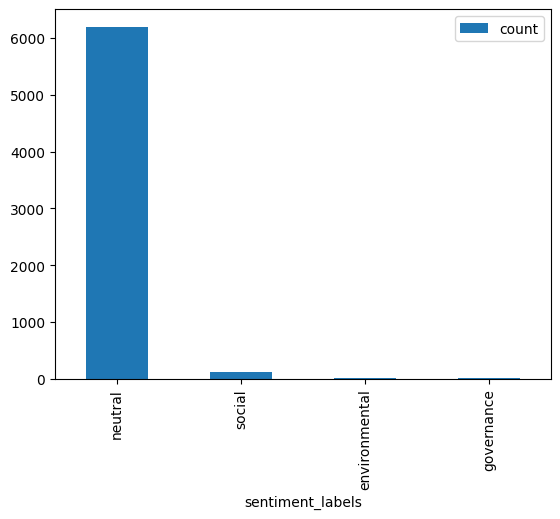

In [13]:
from transformers import BertTokenizer, BertForSequenceClassification
from torch import nn
import os
from ec_helper_function import convert_transcript_to_df
import pandas as pd
import numpy as np

try:
    ec_sequences = pd.read_csv("../data/aapl_ec_transcripts_esg_bert.csv")
except:
    tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')
    esg_model = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-esg',num_labels=4)

    sentiment_dict = {0: "neutral", 1: "environmental", 2: "social", 3: "governance"}

    ec_transcript_files = os.listdir("../data/aapl_ec_transcripts/")
    ec_transcript_files.sort()

    ec_sequences = pd.DataFrame()
    for filename in ec_transcript_files:
        dt = ec_transcript_files[0][:11]
        file_path = f'../data/aapl_ec_transcripts/{filename}'
        with open(file_path, 'r') as file:
            transcript = file.read()
        try:
            earning_call = convert_transcript_to_df(transcript)
            earning_call = earning_call[earning_call.action != "presentation"]
            earning_call.loc[:, "date"] = dt
            ec_sequences = pd.concat((ec_sequences, earning_call.copy()))
        except:
            continue
        
    ec_sequences = ec_sequences.reset_index(drop = True)
    raw_sequences = ec_sequences.text.tolist()

    batch_size = 32
    sequence_batches = [raw_sequences[i:i+batch_size] for i in range(0, len(raw_sequences), batch_size)]

    probs_full, sentiment_labels_full = [], []
    for batch in sequence_batches:
        inputs = tokenizer(batch, padding = "max_length", max_length = 512, return_tensors = "pt", truncation = True)
        #LABEL_0: neutral; LABEL_!: environmental; LABEL_2: social; LABEL_3: governance
        esg = esg_model(**inputs)

        softmax = nn.Softmax(dim = 1)
        probs, sentiment = softmax(esg.logits.detach()).max(dim = 1)
        sentiment_label = [sentiment_dict[s] for s in sentiment.tolist()]
        probs_full.extend(probs)
        sentiment_labels_full.extend(sentiment_label)

    probs_full = [p.numpy() for p in probs_full]
    ec_sequences.loc[:, "sentiment_labels"] = sentiment_labels_full
    ec_sequences.loc[:, "sentiment_label_probabilities"] = probs_full
    ec_sequences.to_csv("../data/aapl_ec_transcripts_esg_bert.csv", index = False)

esg_value_counts = ec_sequences.sentiment_labels.value_counts()
label_occurrences = esg_value_counts.reset_index().plot.bar(x = "sentiment_labels", y = "count")

Furthermore, manually scrolling through example which are identified as ESG, shows that not many of these sequences do not seem to be related to ESG issues in terms of non-finanical factors for future risks of the company. This shows us that maybe a different labeling approach potentially could improve the identification of such sequences.

In [14]:
for idx, row in ec_sequences[ec_sequences.sentiment_labels != "neutral"].iterrows():
    print(f"Text sequence from {row['responsibility']}:")
    print("-"*30)
    print(f"Estimated sentiment: {row['sentiment_labels']}")
    print(f"Corresponding probability: {np.round(row['sentiment_label_probabilities'], 4)}")
    print(row["text"])
    print("-"*100)

Text sequence from firm:
------------------------------
Estimated sentiment: social
Corresponding probability: 0.7918
Cynthia, honestly, it's been a few days and we will need to give it a week or two to really be able to see the impact of it.
----------------------------------------------------------------------------------------------------
Text sequence from firm:
------------------------------
Estimated sentiment: social
Corresponding probability: 0.5153
Yes, a week and-a-half.
----------------------------------------------------------------------------------------------------
Text sequence from firm:
------------------------------
Estimated sentiment: social
Corresponding probability: 0.6423
As it relates primarily to the education market, is that what you want me to address?
----------------------------------------------------------------------------------------------------
Text sequence from analyst:
------------------------------
Estimated sentiment: social
Corresponding probabi

Coming back to the financial tone, [Huang (2022)](https://onlinelibrary.wiley.com/doi/full/10.1111/1911-3846.12832) conduct a similar analysis to the papers presented in the previous chapter "Text analysis in finance". Even though, the results are not directly comparable to the studies by [Frankel et. al (2022)](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3845780) due to different data sets, we can observe that the level of variation of cumulative abnormal returns which can be explained by financial sentiment models is the highest for the domain specific BERT model.

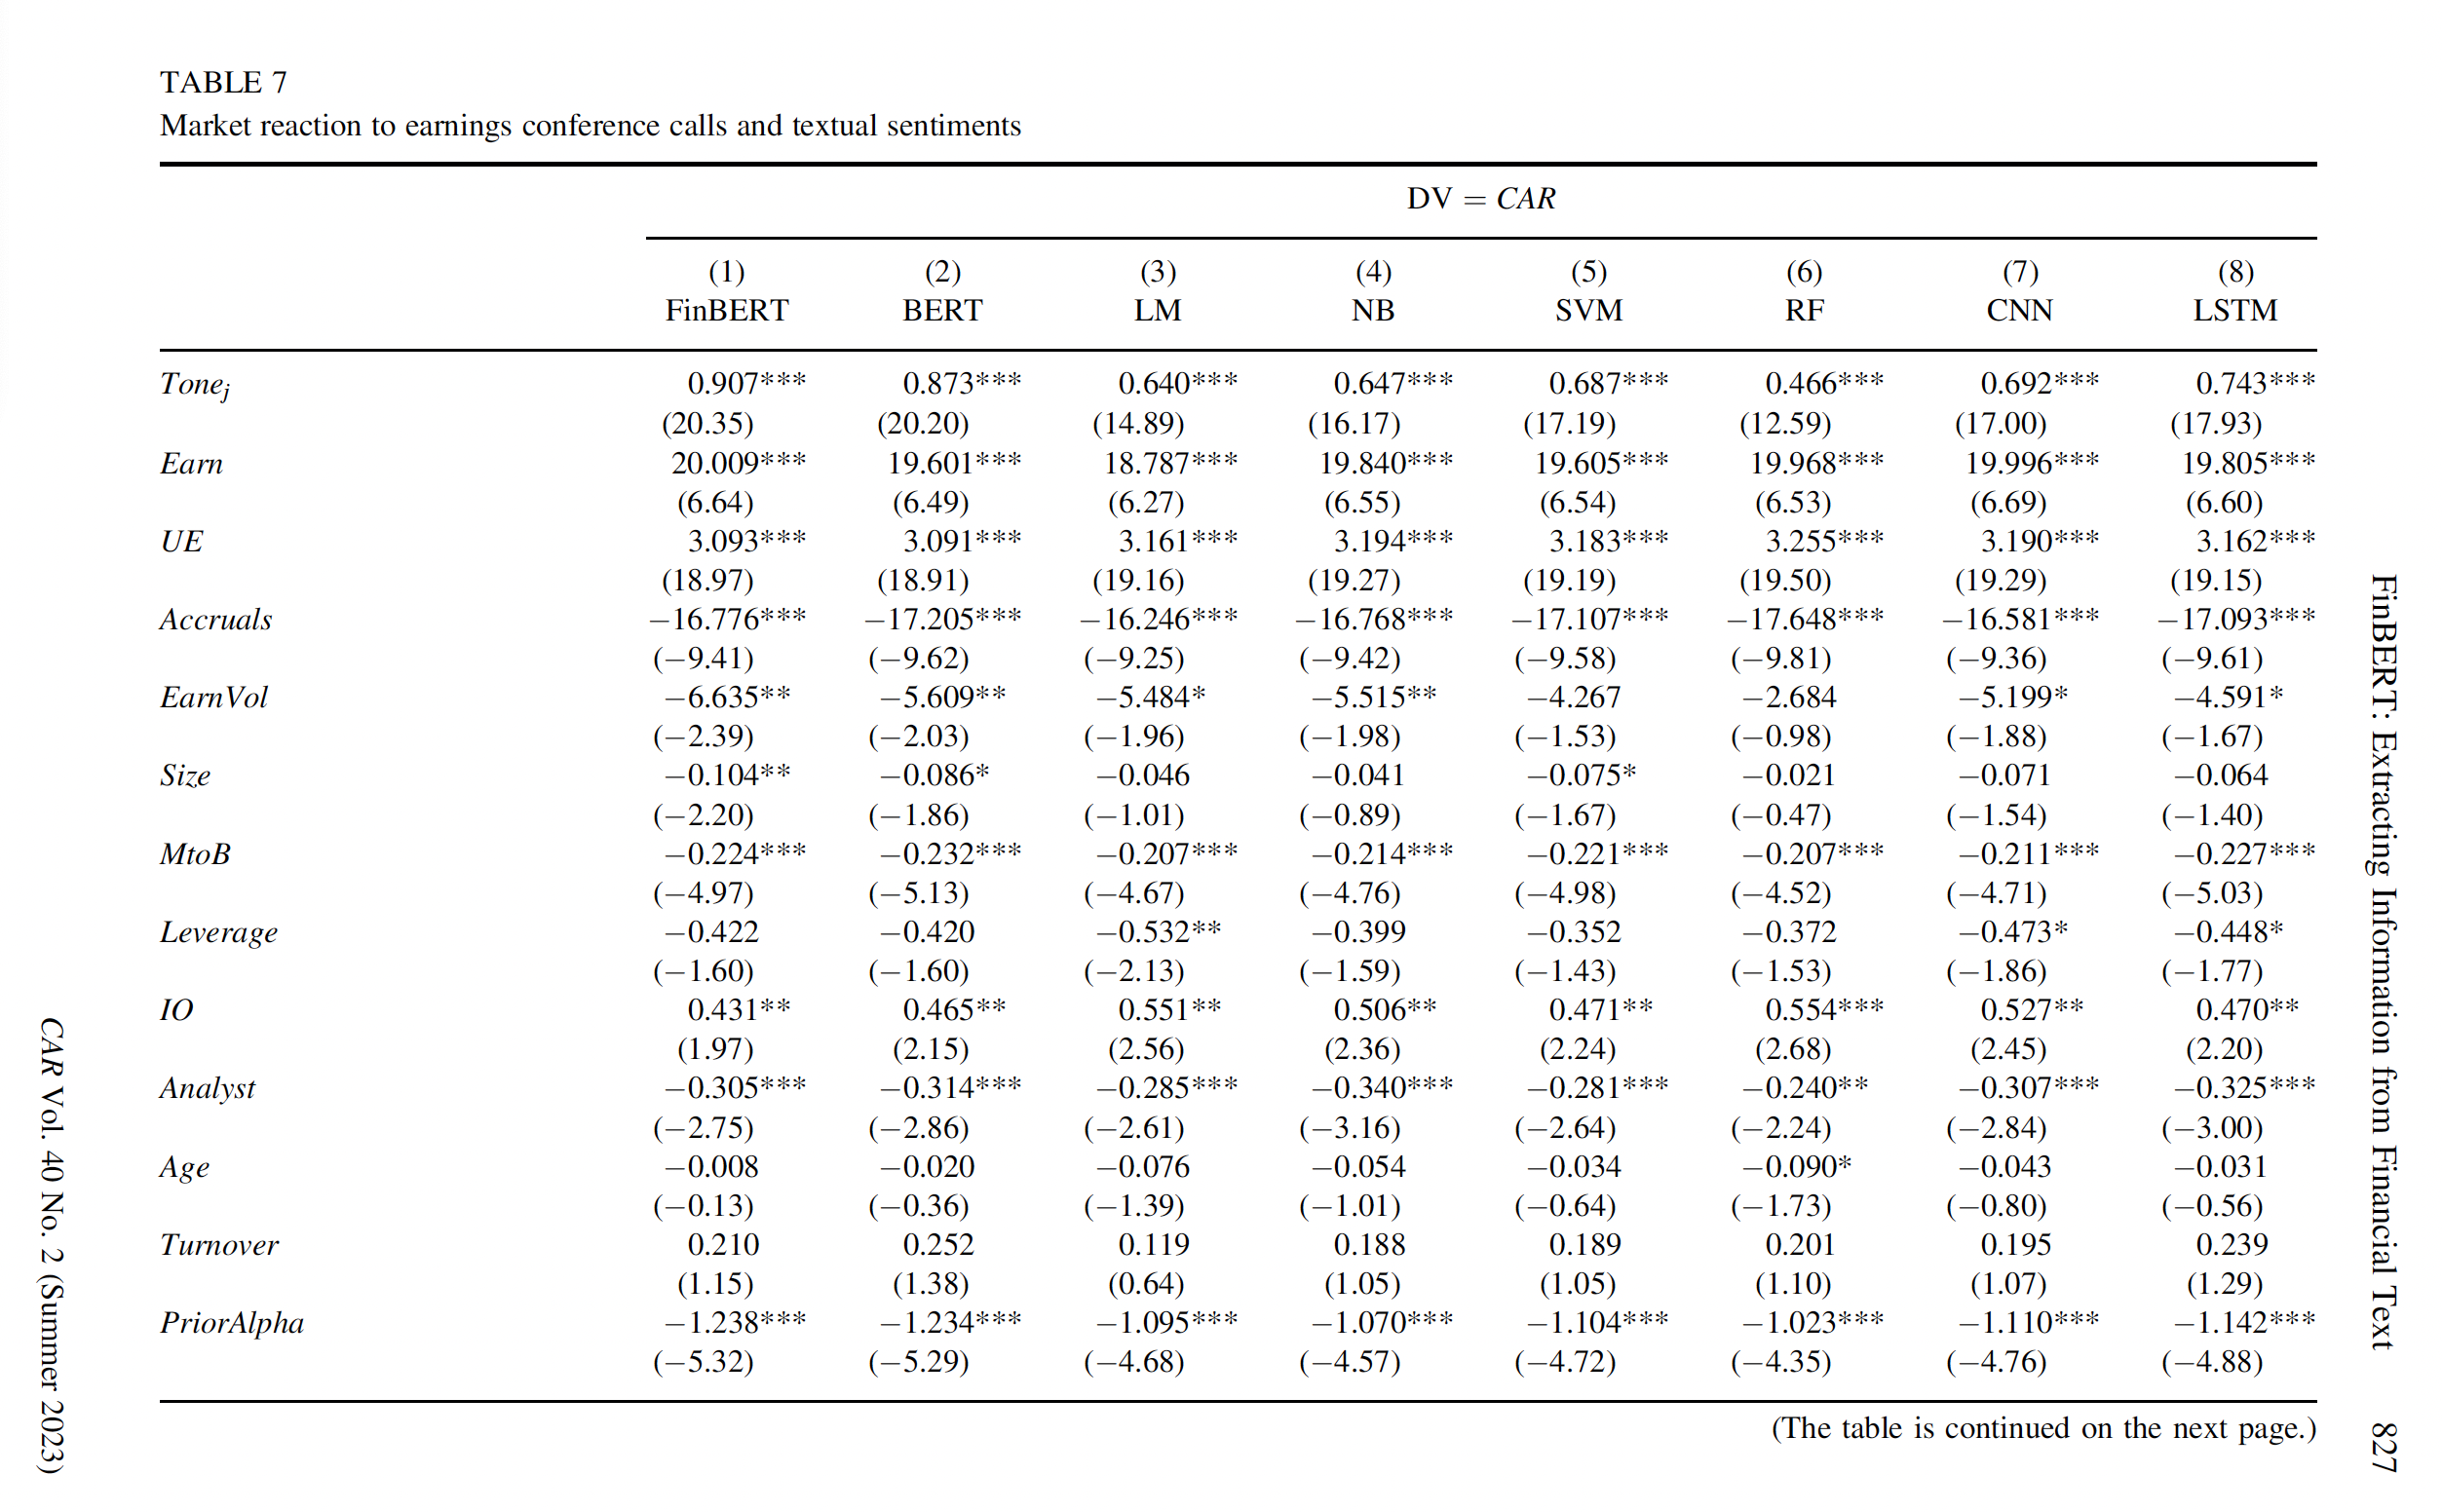

In [15]:
from IPython.display import Image
Image(filename='huang_1.png', width = 900) 

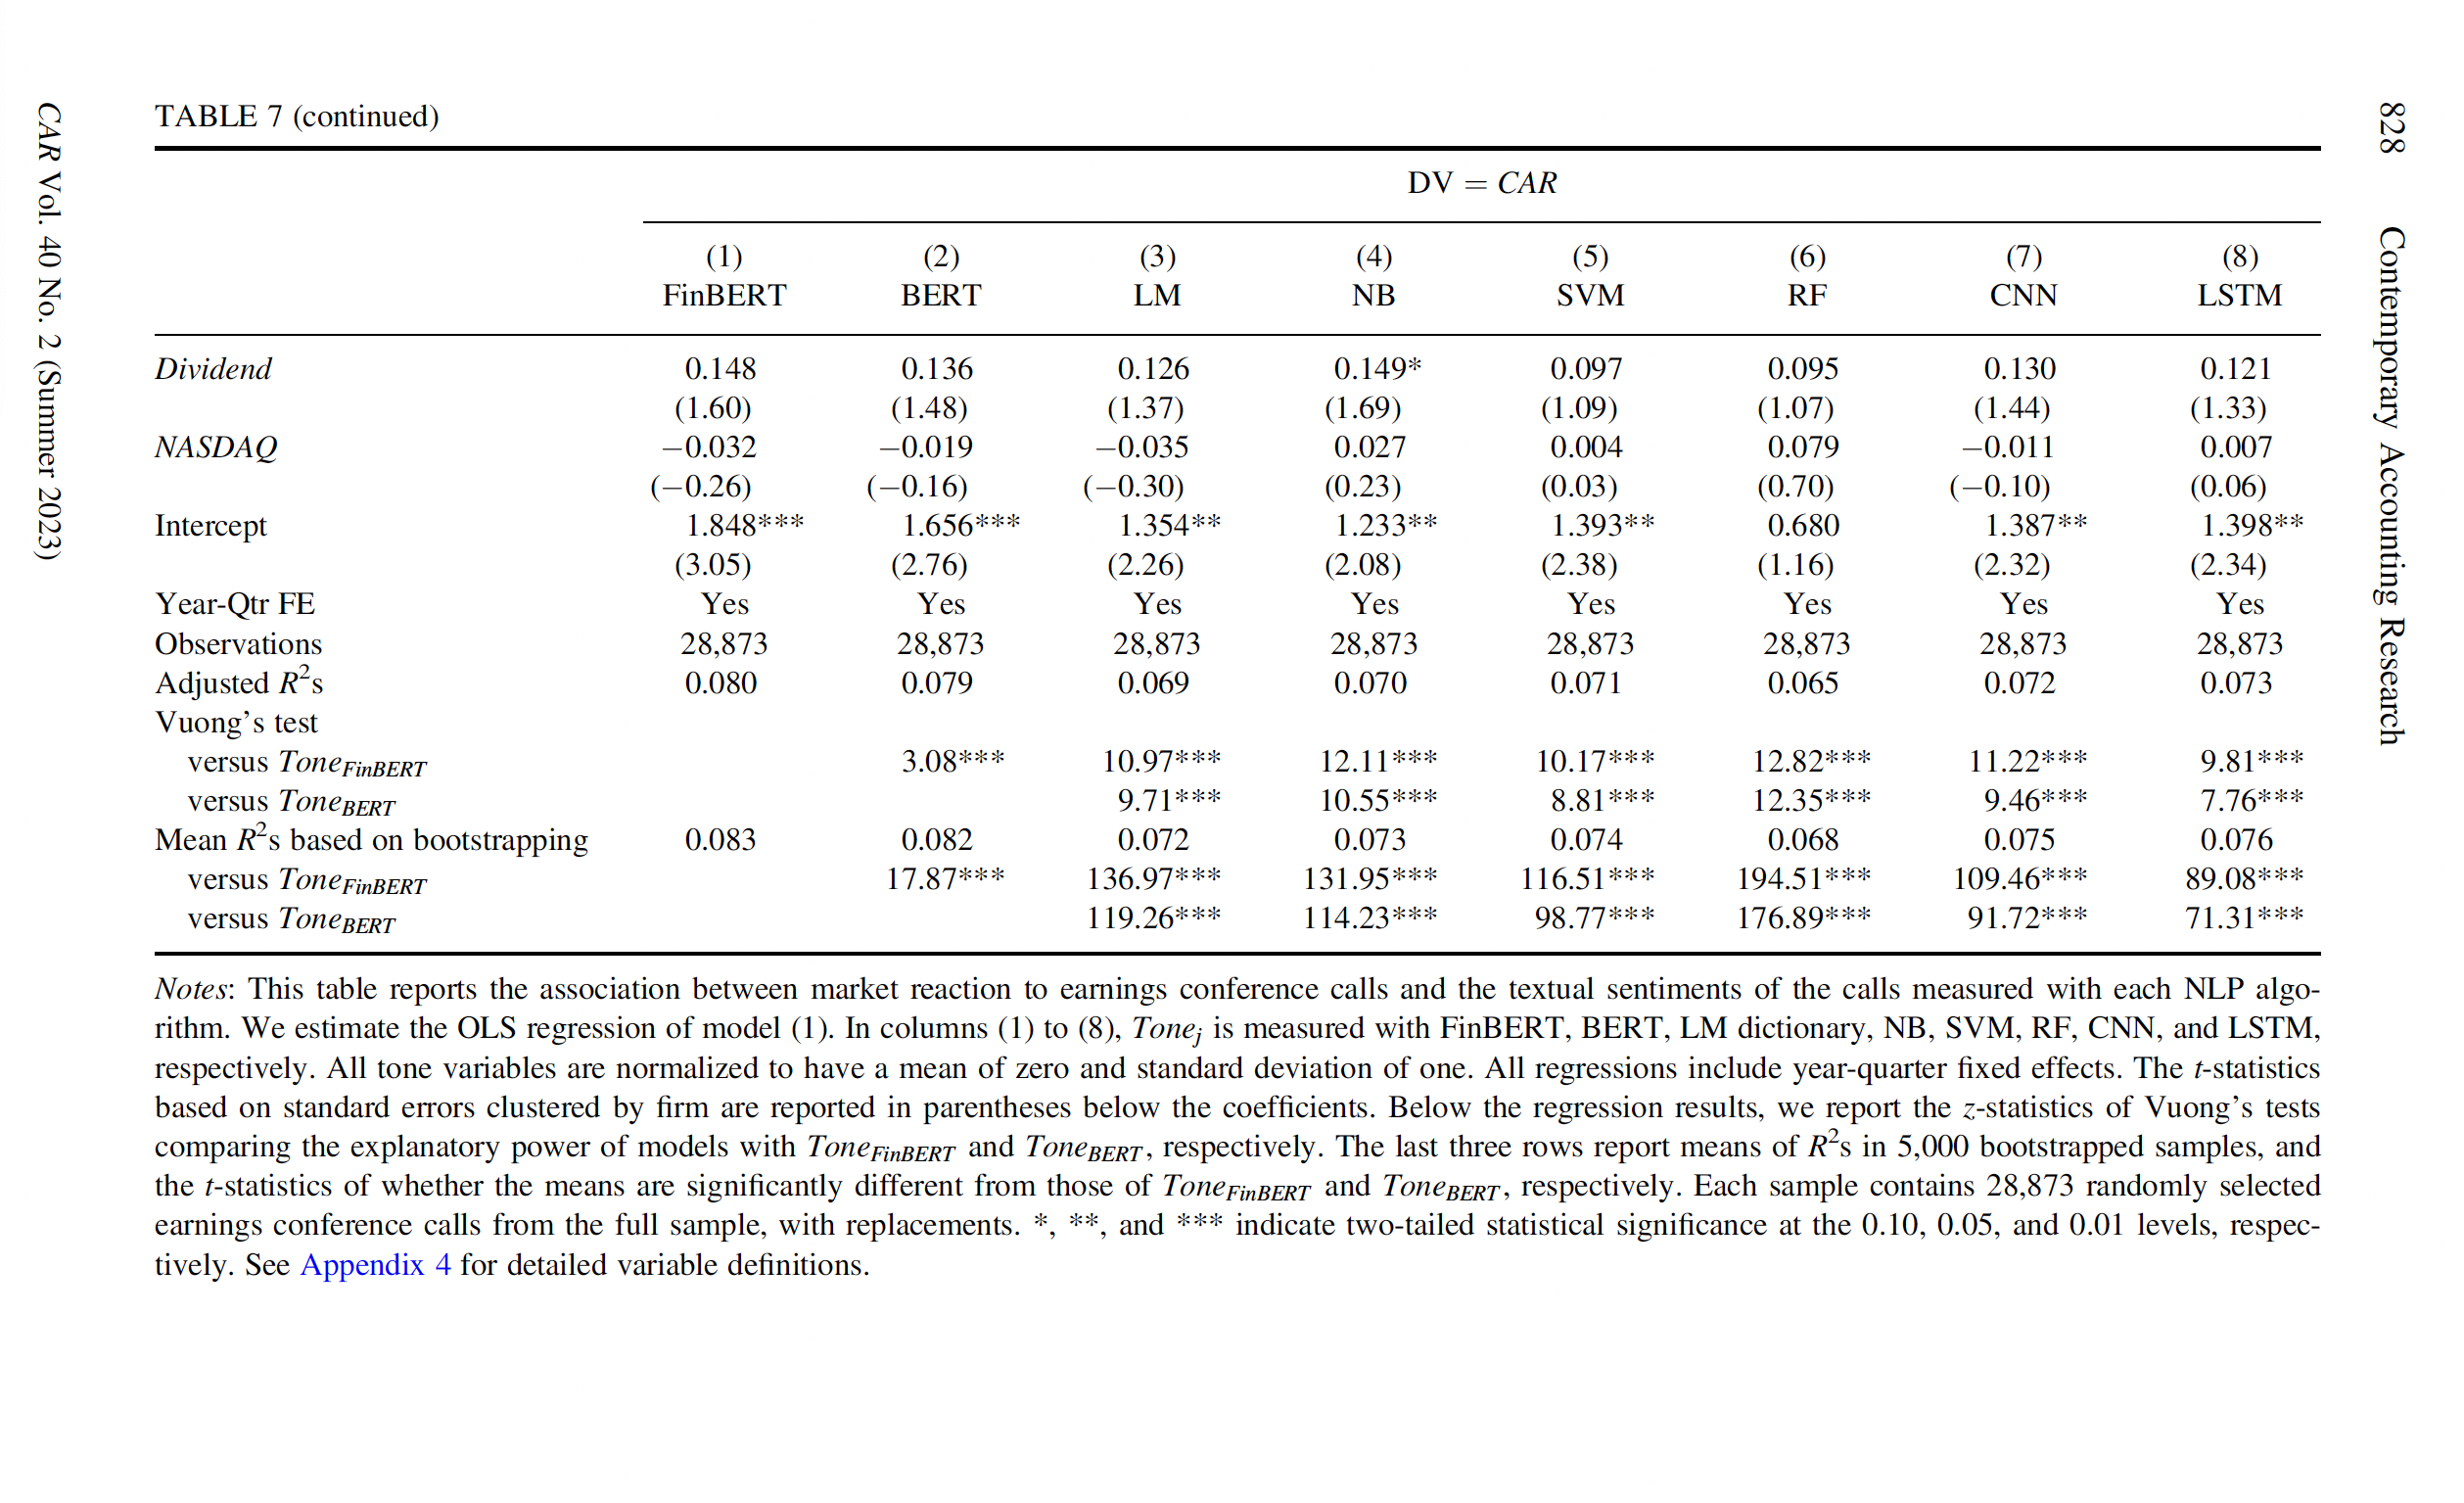

In [16]:
from IPython.display import Image
Image(filename='huang_2.png', width = 900) 